In [2]:
from ATTall_train import *
from shapley import *
from utils import *
from vis_attention import *
from rdkit import Chem

In [3]:
# Load pKa prediction model

reg_model_mat = ATT(multihead_attention=True, return_attention=True, edge_dim=12, num_features=33)
reg_model_mat_path = "/home/lxy/ATT/best_model_23d_pre.pth"
reg_model_mat.load_state_dict(torch.load(reg_model_mat_path, map_location=torch.device('cpu')))
print("Load pretrained model")
reg_model_mat.eval()

Load pretrained model


ATT(
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (initial_conv): GATConv(33, 128, heads=4)
  (head_transform1): Linear(in_features=512, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): GATConv(128, 128, heads=4)
  (head_transform2): Linear(in_features=512, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GATConv(128, 128, heads=4)
  (head_transform3): Linear(in_features=512, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GATConv(128, 128, heads=4)
  (head_transform4): Linear(in_features=512, out_features=128, bias=True)
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mhat): MultiAtomAttention(
    (dropout_layer): Dropout(p=0.2, inplace=False)
    (W_a_q): Linear(in_features=128, out_features=1

## Compare attention weights for pKa prediction before and after correction

In [4]:
smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"

# Create single input to the model
single_data = create_single_data(smiles)    
n_atom = single_data.x.shape[0]

In [5]:
# Adjust input data dimensions
if single_data.x.size(1) < 33:
    # If feature dimension is insufficient, pad with zeros
    single_data.x = F.pad(single_data.x, (0, 33 - single_data.x.size(1)), "constant", 0)
elif single_data.x.size(1) > 33:
    # If feature dimension is excessive, use linear projection
    projection = torch.nn.Linear(single_data.x.size(1), 33)
    single_data.x = projection(single_data.x)


In [6]:
edge_attr = single_data.edge_attr

if edge_attr.size(1) < 12:
    edge_attr = F.pad(edge_attr, (0, 12 - edge_attr.size(1)), "constant", 0)
elif edge_attr.size(1) > 12:
    # If feature dimension is excessive, use linear projection
    projection = torch.nn.Linear(edge_attr.size(1), 12)
    edge_attr = projection(edge_attr)

# Update single_data.edge_attr
single_data.edge_attr = edge_attr

In [7]:
# Extract original multi-head global attention
mol_attention1_before = extract_multi_head_attention(single_data.x, single_data.edge_index, single_data.edge_attr, single_data.batch, reg_model_mat)

# Corrected multi-head global attention
mol_attention1_after = calculate_overall_att(single_data.x, single_data.edge_index, single_data.edge_attr, single_data.batch, reg_model_mat, n_atom)

Main visualization saved to /home/lxy/ToxPred_nitrification-main/img/CC(=O)OC1=CC=CC=C1C(=O)O_23d.svg
Colorbar with thick border saved to /home/lxy/ToxPred_nitrification-main/img/CC(=O)OC1=CC=CC=C1C(=O)O_c23d.svg


(None,
 tensor([1.4822e-16, 5.6812e-22, 3.3112e-16, 3.6493e-17, 1.2051e-15, 5.0000e-01,
         3.4379e+00, 5.2192e-03, 1.0569e+00, 1.3364e-14, 7.6033e+00, 3.8045e-01,
         1.6213e-02]))

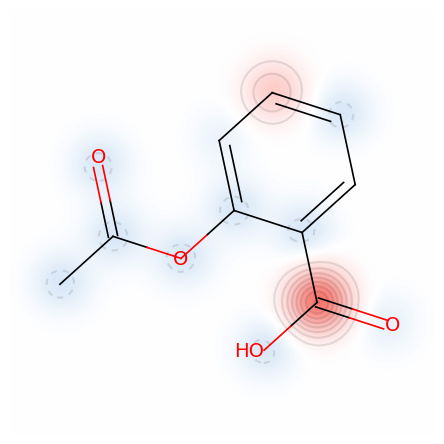

In [9]:
# Before correction
visualize_attention(smiles,mol_attention1_before,output_path='/home/lxy/ATT/img/CC(=O)OC1=CC=CC=C1C(=O)O_23d.svg',colorbar_path='/home/lxy/ATT/img/CC(=O)OC1=CC=CC=C1C(=O)O_c23d.svg'), mol_attention1_before.sum(axis=0)

Main visualization saved to /home/lxy/ToxPred_nitrification-main/img/CC(=O)OC1=CC=CC=C1C(=O)O_23da.svg
Colorbar with thick border saved to /home/lxy/ToxPred_nitrification-main/img/CC(=O)OC1=CC=CC=C1C(=O)O_c23da.svg


(None,
 tensor([0.6951, 0.5035, 0.7520, 1.4209, 0.3083, 0.6217, 0.7044, 0.7094, 0.4872,
         0.5279, 0.2797, 0.9063, 5.0837]))

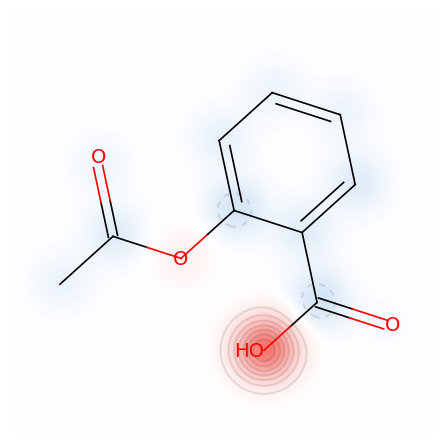

In [10]:
# After correction
visualize_attention(smiles, mol_attention1_after,output_path='/home/lxy/ATT/img/CC(=O)OC1=CC=CC=C1C(=O)O_23da.svg',colorbar_path='/home/lxy/ATT/img/CC(=O)OC1=CC=CC=C1C(=O)O_c23da.svg'), mol_attention1_after.sum(axis=0)

## Determine the contribution of important susbtructures with Shapley values

In [11]:
smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"

# Create single input to the model
single_data = create_single_data(smiles)
n_atom = single_data.x.shape[0]
m = Chem.MolFromSmiles(smiles)



In [12]:
# Adjust input data dimensions
if single_data.x.size(1) < 33:
    # If feature dimension is insufficient, pad with zeros
    single_data.x = F.pad(single_data.x, (0, 33 - single_data.x.size(1)), "constant", 0)
elif single_data.x.size(1) > 33:
    # If feature dimension is excessive, use linear projection
    projection = torch.nn.Linear(single_data.x.size(1), 33)
    single_data.x = projection(single_data.x)


In [13]:
edge_attr = single_data.edge_attr

if edge_attr.size(1) < 12:
    edge_attr = F.pad(edge_attr, (0, 12 - edge_attr.size(1)), "constant", 0)
elif edge_attr.size(1) > 12:
    # If feature dimension is excessive, use linear projection
    projection = torch.nn.Linear(edge_attr.size(1), 12)
    edge_attr = projection(edge_attr)

# Update single_data.edge_attr
single_data.edge_attr = edge_attr

In [14]:
# Corrected attention
corrected_attention = calculate_overall_att(single_data.x, single_data.edge_index, single_data.edge_attr, single_data.batch, reg_model_mat, n_atom)

<Figure size 2400x1800 with 0 Axes>

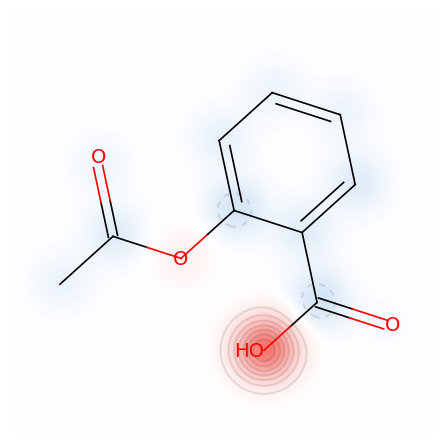

(None,
 tensor([0.6951, 0.5035, 0.7520, 1.4209, 0.3083, 0.6217, 0.7044, 0.7094, 0.4872,
         0.5279, 0.2797, 0.9063, 5.0837]))

In [15]:
# Show important substructures
visualize_attention(smiles, corrected_attention), mol_attention1_after.sum(axis=0)

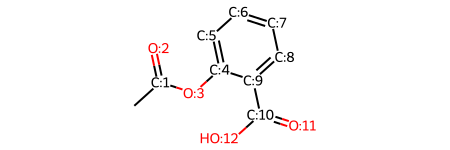

In [16]:
# Check atom index
mol_with_atom_index(m)

In [18]:
important_substuctures = [[5,7]]


# Calculate shapley values
calc_subgraphs_shapley(reg_model_mat, single_data, important_substuctures, value_func_pred)

{(5, 7): -0.002940319773272995}

In [19]:
smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"

# Create single input to the model
single_data = create_single_data(smiles)
n_atom = single_data.x.shape[0]
m = Chem.MolFromSmiles(smiles)



In [20]:
# Adjust input data dimensions
if single_data.x.size(1) < 33:
    # If feature dimension is insufficient, pad with zeros
    single_data.x = F.pad(single_data.x, (0, 33 - single_data.x.size(1)), "constant", 0)
elif single_data.x.size(1) > 33:
    # If feature dimension is excessive, use linear projection
    projection = torch.nn.Linear(single_data.x.size(1), 33)
    single_data.x = projection(single_data.x)


In [21]:
edge_attr = single_data.edge_attr

if edge_attr.size(1) < 12:
    edge_attr = F.pad(edge_attr, (0, 12 - edge_attr.size(1)), "constant", 0)
elif edge_attr.size(1) > 12:
    # If feature dimension is excessive, use linear projection
    projection = torch.nn.Linear(edge_attr.size(1), 12)
    edge_attr = projection(edge_attr)

# Update single_data.edge_attr
single_data.edge_attr = edge_attr

In [22]:
# Corrected attention
corrected_attention = calculate_overall_att(single_data.x, single_data.edge_index, single_data.edge_attr, single_data.batch, reg_model_mat, n_atom)

<Figure size 2400x1800 with 0 Axes>

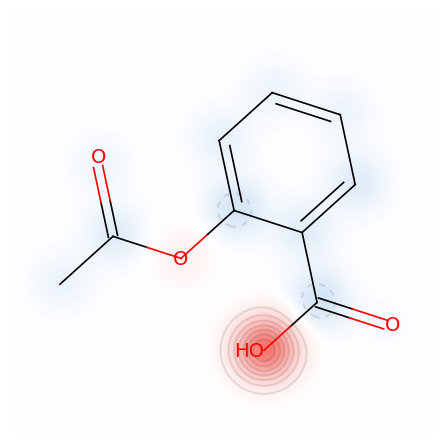

(None,
 tensor([0.6951, 0.5035, 0.7520, 1.4209, 0.3083, 0.6217, 0.7044, 0.7094, 0.4872,
         0.5279, 0.2797, 0.9063, 5.0837]))

In [23]:
# Show important substructures
visualize_attention(smiles, corrected_attention), mol_attention1_after.sum(axis=0)

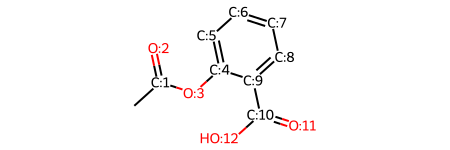

In [24]:
mol_with_atom_index(m)

In [26]:
important_substuctures = [[0,1,2]]

# Calculate shapley values
calc_subgraphs_shapley(reg_model_mat, single_data, important_substuctures, value_func_pred)

{(0, 1, 2): -0.03246745075803075}